In [ ]:
import argparse
import os
import torch

from exp.exp_informer import Exp_Informer

parser = argparse.ArgumentParser(description='[Informer] Long Sequences Forecasting')

parser.add_argument('--model', type=str, required=True, default='informer',help='model of experiment, options: [informer, informerstack, informerlight(TBD)]')

parser.add_argument('--data', type=str, required=True, default='ETTh1', help='data')
parser.add_argument('--root_path', type=str, default='./data/ETT/', help='root path of the data file')
parser.add_argument('--data_path', type=str, default='ETTh1.csv', help='data file')
parser.add_argument('--features', type=str, default='M', help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')
parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')
parser.add_argument('--freq', type=str, default='h', help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location of model checkpoints')

parser.add_argument('--seq_len', type=int, default=96, help='input sequence length of Informer encoder')
parser.add_argument('--label_len', type=int, default=48, help='start token length of Informer decoder')
parser.add_argument('--pred_len', type=int, default=24, help='prediction sequence length')
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

parser.add_argument('--enc_in', type=int, default=7, help='encoder input size')
parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')
parser.add_argument('--c_out', type=int, default=7, help='output size')
parser.add_argument('--d_model', type=int, default=512, help='dimension of model')
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')
parser.add_argument('--s_layers', type=str, default='3,2,1', help='num of stack encoder layers')
parser.add_argument('--d_ff', type=int, default=2048, help='dimension of fcn')
parser.add_argument('--factor', type=int, default=5, help='probsparse attn factor')
parser.add_argument('--padding', type=int, default=0, help='padding type')
parser.add_argument('--distil', action='store_false', help='whether to use distilling in encoder, using this argument means not using distilling', default=True)
parser.add_argument('--dropout', type=float, default=0.05, help='dropout')
parser.add_argument('--attn', type=str, default='prob', help='attention used in encoder, options:[prob, full]')
parser.add_argument('--embed', type=str, default='timeF', help='time features encoding, options:[timeF, fixed, learned]')
parser.add_argument('--activation', type=str, default='gelu',help='activation')
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in ecoder')
parser.add_argument('--do_predict', action='store_true', help='whether to predict unseen future data')
parser.add_argument('--mix', action='store_false', help='use mix attention in generative decoder', default=True)
parser.add_argument('--cols', type=str, nargs='+', help='certain cols from the data files as the input features')
parser.add_argument('--num_workers', type=int, default=0, help='data loader num workers')
parser.add_argument('--itr', type=int, default=2, help='experiments times')
parser.add_argument('--train_epochs', type=int, default=6, help='train epochs')
parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')
parser.add_argument('--patience', type=int, default=3, help='early stopping patience')
parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')
parser.add_argument('--des', type=str, default='test',help='exp description')
parser.add_argument('--loss', type=str, default='mse',help='loss function')
parser.add_argument('--lradj', type=str, default='type1',help='adjust learning rate')
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)
parser.add_argument('--inverse', action='store_true', help='inverse output data', default=False)

parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')ECL
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0,1,2,3',help='device ids of multile gpus')

args = parser.parse_args()

args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

data_parser = {
    'ETTh1':{'data':'ETTh1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTh2':{'data':'ETTh2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm1':{'data':'ETTm1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm2':{'data':'ETTm2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'WTH':{'data':'WTH.csv','T':'WetBulbCelsius','M':[12,12,12],'S':[1,1,1],'MS':[12,12,1]},
    'ECL':{'data':'ECL.csv','T':'MT_320','M':[321,321,321],'S':[1,1,1],'MS':[321,321,1]},
    'Solar':{'data':'solar_AL.csv','T':'POWER_136','M':[137,137,137],'S':[1,1,1],'MS':[137,137,1]},
}
if args.data in data_parser.keys():
    data_info = data_parser[args.data]
    args.data_path = data_info['data']
    args.target = data_info['T']
    args.enc_in, args.dec_in, args.c_out = data_info[args.features]

args.s_layers = [int(s_l) for s_l in args.s_layers.replace(' ','').split(',')]
args.detail_freq = args.freq
args.freq = args.freq[-1:]
ECLimport matplotlib.pyplot as plt
import numpy as np

sample1 = [1, 2, 3, 4, 5]
sample2 = [5, 4, 3, 2, 1]

plt.plot(sample1, label='Sample 1', marker='o', linestyle='-')
plt.plot(sample2, label='Sample 2', marker='s', linestyle='--')

plt.xlabel('X-Axis Label')
plt.ylabel('Y-Axis Label')
plt.legend()

plt.show()

print('Args in experiment:')
print(args)

Exp = Exp_Informer

for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features,
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor,
                args.embed, args.distil, args.mix, args.des, ii)

    exp = Exp(args) # set experiments
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)

    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    if args.do_predict:
        print('>>>>>>>predicting : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
        exp.predict(setting, True)

    torch.cuda.empty_cache()ECL

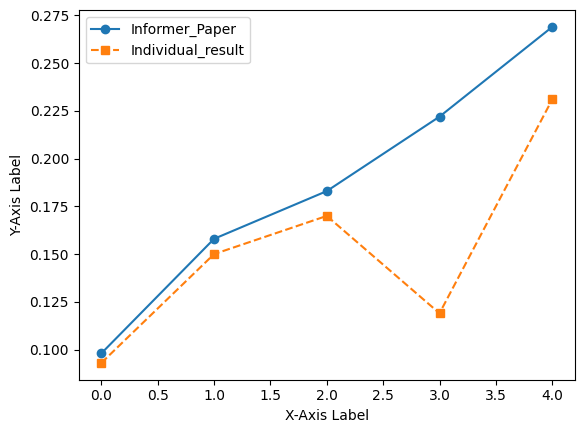

In [ ]:
#plotting of test results for ETTH1 FOR MSE
import matplotlib.pyplot as plt
import numpy as np

sample1 = [0.098, 0.158, 0.183, 0.222, 0.269]
sample2 = [0.093, 0.150, 0.170, 0.119, 0.231]

plt.plot(sample1, label='Informer_Paper', marker='o', linestyle='-')
plt.plot(sample2, label='Individual_result', marker='s', linestyle='--')

plt.xlabel('X-Axis Label')
plt.ylabel('Y-Axis Label')
plt.legend()

plt.show()


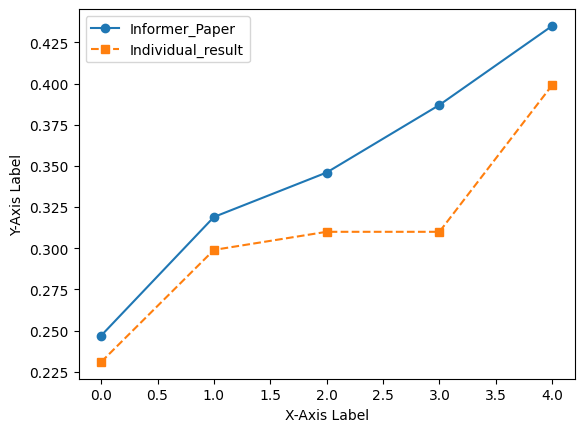

In [ ]:
#plotting of test results for ETTH1 FOR MAE
import matplotlib.pyplot as plt
import numpy as np

sample1 = [0.247, 0.319, 0.346, 0.387, 0.435]
sample2 = [0.231, 0.299, 0.310, 0.310, 0.399]

plt.plot(sample1, label='Informer_Paper', marker='o', linestyle='-')
plt.plot(sample2, label='Individual_result', marker='s', linestyle='--')

plt.xlabel('X-Axis Label')
plt.ylabel('Y-Axis Label')
plt.legend()

plt.show()


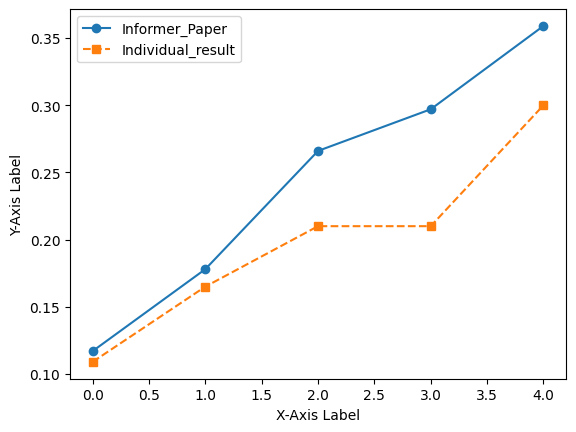

In [4]:
#plotting of test results for WEATHER FOR MSE
import matplotlib.pyplot as plt
import numpy as np

sample1 = [0.117, 0.178, 0.266, 0.297, 0.359]
sample2 = [0.109, 0.165, 0.210, 0.210, 0.300]

plt.plot(sample1, label='Informer_Paper', marker='o', linestyle='-')
plt.plot(sample2, label='Individual_result', marker='s', linestyle='--')

plt.xlabel('X-Axis Label')
plt.ylabel('Y-Axis Label')
plt.legend()

plt.show()


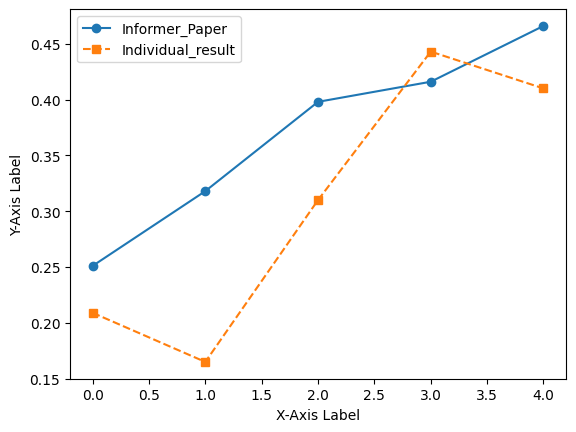

In [5]:
#plotting of test results for WEATHER FOR MAE
import matplotlib.pyplot as plt
import numpy as np

sample1 = [0.251, 0.318, 0.398, 0.416, 0.466]
sample2 = [0.209, 0.165, 0.310, 0.443, 0.410]

plt.plot(sample1, label='Informer_Paper', marker='o', linestyle='-')
plt.plot(sample2, label='Individual_result', marker='s', linestyle='--')

plt.xlabel('X-Axis Label')
plt.ylabel('Y-Axis Label')
plt.legend()

plt.show()
